<a id="index"></a>
# A modular spike sorting pipeline for `Axona` data

The notebook largely follows the [spiketutorial notebook from the Sep. 2020 developer workshop](https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb): 

In this notebook we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison for axona raw, axona unit and intan data. We will be using `spikeinterface` from the [SpikeInterface](https://github.com/SpikeInterface) github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

We will show how to

1. [Install dependencies](#install_dependencies)
2. [load data with spikeextractors](#load_data)
3. [Preprocess the signals](#preprocess)
4. [Cache data](#cache)
5. [Spike sort](#spike_sorting)
   * [Klusta](#klusta)
   * [mountainsort4](#mountainsort4)
   * [Ironclust](#ironclust)
   * [spyking circus](#spykingcircus)
   * [tridesclous](#tridesclous)
6. [Postprocess the signals](#postprocessing)
7. [Curate the spike sorting output](#spike_curation) using 1) quality metrics (automatic), 2) [Phy](https://github.com/cortex-lab/phy) (manual), and 3) consensus-based curation
8. [Export results to NWB](#export_nwb)
9. [Export results to TINT](#export_tint)


<a id='install_dependencies'></a>
# Install dependencies
[back to index](#index)

TODO streamline installation with requirements.txt, ultimately we will only use spikeinterface

We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`

In addition, for the conda environment, you need to install [Phy](https://github.com/cortex-lab/phy) for the manual curation step.

`pip install phy --pre --upgrade`


Alternatively, you can install the requirements using the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

(in this case Phy should be automatically installed)

Note that some spike sorters require matlab or additional dependencies, which need to be installed separately. For an overview of possible spike sorters and their dependencies see https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html.

In [1]:
!which python

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python


In [3]:
# Ultimately this is the only command needed, but for now we need
# to install from github to obtain work in progress.

#!pip install spikeinterface

Once axonarecordingextractors are integrated into spikeextractors, 
installing spikeinterface should be sufficient. For now we also need to
clone spikeextractors and python-neo with the necessary components
(e.g. branch axonarawio for python-neo).

In [4]:
!git clone https://github.com/catalystneuro/python-neo.git

fatal: destination path 'python-neo' already exists and is not an empty directory.


In [5]:
!ls -l

total 2472
-rwxrwxrwx 1 steburg steburg     198 Apr 13 21:11 Dockerfile
-rwxrwxrwx 1 steburg steburg   54974 Apr  4 15:33 SpikeInterface_Tutorial.ipynb
-rwxrwxrwx 1 steburg steburg     800 Apr 12 20:23 axona_tutorial_re.nwb
-rwxrwxrwx 1 steburg steburg  171124 Apr  5 17:18 axona_tutorial_se.nwb
-rwxrwxrwx 1 steburg steburg     451 Apr 13 21:11 channel_groups.prb
-rwxrwxrwx 1 steburg steburg    2208 Apr 12 20:27 export_from_spikeinterface_to_tint.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  1 21:38 ironclust
drwxrwxrwx 1 steburg steburg    4096 Apr 13 09:53 klusta_docker
-rwxrwxrwx 1 steburg steburg  236408 Apr 11 21:26 m2_modular_pipeline_spikesorters_docker.ipynb
-rwxrwxrwx 1 steburg steburg 1659656 Apr 14 10:45 milestone2_modular_pipeline_colab.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  4 15:16 phy_KL
drwxrwxrwx 1 steburg steburg    4096 Apr  1 19:29 python-neo
drwxrwxrwx 1 steburg steburg    4096 Apr 10 17:01 spikeextractors
-rwxrwxrwx 1 steburg steburg  149348 Apr 13 21:45 

In [6]:
%cd ./python-neo
!python3 setup.py develop
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
running develop
running egg_info
writing neo.egg-info/PKG-INFO
writing dependency_links to neo.egg-info/dependency_links.txt
writing requirements to neo.egg-info/requires.txt
writing top-level names to neo.egg-info/top_level.txt
reading manifest file 'neo.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'drafts'
no previously-included directories found matching 'doc/build'
writing manifest file 'neo.egg-info/SOURCES.txt'
running build_ext
Creating /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/neo.egg-link (link to .)
Adding neo 0.9.0 to easy-install.pth file

Installed /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
Processing dependencies for neo==0.9.0
Searching for quantities>=0.12.1
Reading https://pypi.org/simple/quantities/
Best match: quantities 0.12.4
Processing quantities-0.12.4.tar.gz
Writing /tmp/easy_install-

In [68]:
!git clone https://github.com/catalystneuro/spikeextractors.git

fatal: destination path 'spikeextractors' already exists and is not an empty directory.


In [7]:
%cd ./spikeextractors
!python3 setup.py develop
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
running develop
running egg_info
writing spikeextractors.egg-info/PKG-INFO
writing dependency_links to spikeextractors.egg-info/dependency_links.txt
writing requirements to spikeextractors.egg-info/requires.txt
writing top-level names to spikeextractors.egg-info/top_level.txt
reading manifest file 'spikeextractors.egg-info/SOURCES.txt'
writing manifest file 'spikeextractors.egg-info/SOURCES.txt'
running build_ext
Creating /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikeextractors.egg-link (link to .)
Adding spikeextractors 0.9.5 to easy-install.pth file

Installed /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
Processing dependencies for spikeextractors==0.9.5
Searching for tqdm
Reading https://pypi.org/simple/tqdm/
Best match: tqdm 4.59.0
Processing tqdm-4.59.0-py2.py3-none-any.whl
Installing tqdm-4.59.0-py2.py3-none-any.whl to /mnt/d/spikeinterface/hussaini-to-nwb/ti

Switch to correct branches

In [8]:
%cd python-neo
!git checkout axonarawio
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
Already on 'axonarawio'
Your branch is up to date with 'origin/axonarawio'.
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv


In [9]:
%cd spikeextractors
!git checkout axonaextractor
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
Already on 'axonaextractor'
Your branch is up to date with 'origin/axonaextractor'.
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv


Install other spikeinterface modules using pip (this may take a few minutes). 

In [10]:
!pip install spiketoolkit spikesorters spikecomparison spikewidgets

     |████████████████████████████████| 67 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 1.3 MB/s eta 0:00:01
  Using cached spikecomparison-0.3.2-py3-none-any.whl (28 kB)
  Using cached networkx-2.5-py3-none-any.whl (1.6 MB)
  Using cached pandas-1.2.3-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
  Using cached scikit_learn-0.24.1-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
     |████████████████████████████████| 27.2 MB 1.5 MB/s eta 0:00:01     |███████████████████████████████ | 26.4 MB 9.2 MB/s eta 0:00:01
  Using cached spikefeatures-0.1.2.tar.gz (4.5 kB)
  Using cached spikemetrics-0.2.4.tar.gz (18 kB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached MEAutility-1.4.8.tar.gz (33 kB)
     |████████████████████████████████| 10.3 MB 4.2 MB/s eta 0:00:01    |██████▍                         | 2.1 MB 5.8 MB/s eta 0:00:02     |██████████████████████████████▎ | 9.7 MB 4.2 MB/s eta 0:00:01
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB

  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-zvap1k0e/MEAutility/setup.py'"'"'; __file__='"'"'/tmp/pip-install-zvap1k0e/MEAutility/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-7v4e8p3m
       cwd: /tmp/pip-install-zvap1k0e/MEAutility/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for MEAutility
  Running setup.py clean for MEAutility
Failed to build spiketoolkit spikesorters spikewidgets spikefeatures sp

Finally, we should downgrade h5py to version 2.10.0 to be as compatible as possible with spikesorters

In [3]:
!pip install h5py==2.10.0

  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)


__Note__: You need to restart the kernel before you can import the newly installed packages.

Import packages

In [1]:
%matplotlib inline

# General data handling and visualization
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({'font.size':14})

# SpikeInterface
import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc

print(sys.version, sys.platform, sys.executable)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0] linux /home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/bin/python


We can see all existing recordingextractors, as well as the ones installed and available to us with the following commands.

In [2]:
se.recording_extractor_full_list

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysNPIXRecordingExtractor,
 spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spyking

In [3]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysNPIXRecordingExtractor,
 spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextract

<a id='load_data'></a>
# 2. Load data
[back to index](#index)

Set path and base filename and create an `AxonaRecordingExtractor` instance. The `AxonaRecordingExtractor` will process .bin data together with a .set file. It is sufficient to pass the base filename (without ending), assuming that both files are in the same directory (.bin or .set extensions will also work). 

In [2]:
dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin'
base_filename = 'axona_sample'
filename = os.path.join(dir_name, base_filename + '.set')
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample.set


Choose which type of data you would like to ingest.

`AxonaRecordingExtractor` reads from the `.bin` file. `AxonaUnitRecordingExtractor` reads from the `.X` files.

In [3]:
recording = se.AxonaUnitRecordingExtractor(filename=filename, noise_std=15)

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). 

Here we load information from the recording using the built-in functions from the RecordingExtractor.

In [4]:
print('Type of recorindextractor:', type(recording))
print('Channel ids: {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. samples = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(
    start_frame=0, end_frame=48000, channel_ids=2))))
print('Location of third electrode = {}'.format(recording.get_channel_property(channel_id=2, property_name='location')))

Type of recorindextractor: <class 'spikeextractors.extractors.axonaunitrecordingextractor.axonaunitrecordingextractor.AxonaUnitRecordingExtractor'>
Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Num. channels = 16
Sampling frequency = 48000 Hz
Num. samples = 57600
Stdev. on third channel = 20.367971420288086
Location of third electrode = [nan nan]


The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data:

Visualize channels in time domain (from 2.0 to 2.1 seconds).

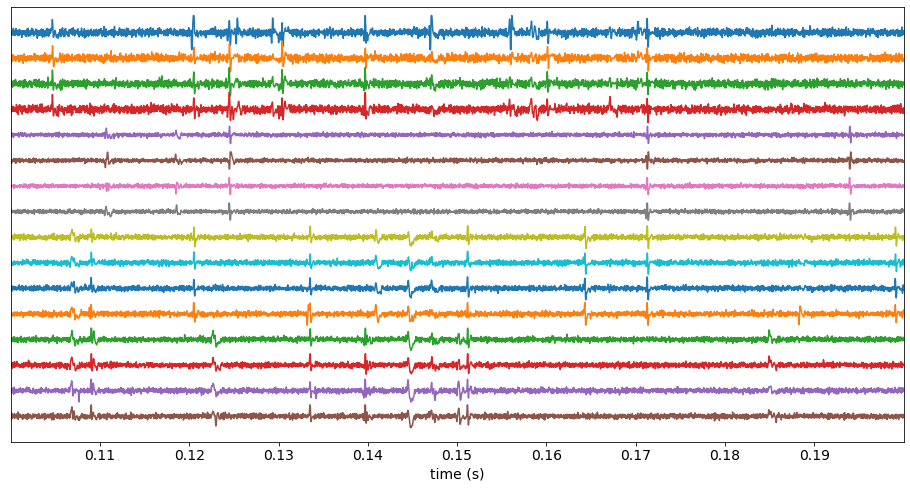

In [5]:
w_ts = sw.plot_timeseries(recording, trange=[0.1, 0.2])

Visualize data from a subset of 8 channels in the frequency domain.

'end_frame' set to 57600


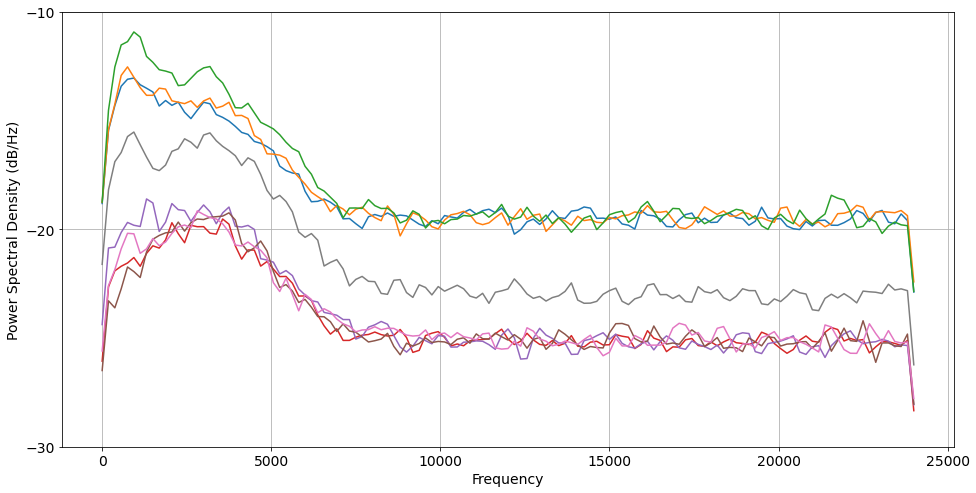

In [6]:
w_sp = sw.plot_spectrum(recording, trange=[0, 5], channels=[1, 2, 3, 4, 5, 6, 7, 8])

It often makes sense to group electrodes together, for instance if they belong to the same tetrode. When reading Axona data channels are automatically grouped by tetrode membership by reading the information form the .set file. If desired, or if using a different recording system where groups are not automatically assigned, the `set_channel_groups()` method can be used. Correspondingly, we can view the `group` property using the `get_channel_groups` method. 

An alternative way to obtain channel groups is by loading a so called `.prb` file containing channel grouping and physical channel locations. We do not need it here, but it is well explained in this [spikeinterface tutorial](https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb).

In [7]:
print(f'Channel groups:\n{recording.get_channel_groups()}')

Channel groups:
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Some spike sorters (e.g. ironclust) require channel locations. So we will create a fake geometry keeping electrodes on single tetrodes close together. One could use a `.prb` file to accomplish this, but we will simply assign locations with the `set_channel_locations()` method. If the actual geometry is known, you can of course use that instead. 

In [8]:
recording.get_channel_ids()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [9]:
recording.set_channel_locations(locations=[[0,0],[0,1],[0,2],[0,3],
                                           [0,10],[0,11],[0,12],[0,13],
                                           [0,20],[0,21],[0,22],[0,23],
                                           [0,30],[0,31],[0,32],[0,33]],
                                channel_ids=recording.get_channel_ids())

We now have the additional channel property `location`.

In [10]:
print('Channel ids:', recording.get_channel_ids())
print('Loaded properties', recording.get_shared_channel_property_names())

# 'group' and 'location' can be returned as lists:
print('Channel groups:', recording.get_channel_groups())
print('Channel locations:\n', recording.get_channel_locations())

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Loaded properties ['gain', 'group', 'location', 'name', 'offset']
Channel groups: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Channel locations:
 [[ 0.  0.]
 [ 0.  1.]
 [ 0.  2.]
 [ 0.  3.]
 [ 0. 10.]
 [ 0. 11.]
 [ 0. 12.]
 [ 0. 13.]
 [ 0. 20.]
 [ 0. 21.]
 [ 0. 22.]
 [ 0. 23.]
 [ 0. 30.]
 [ 0. 31.]
 [ 0. 32.]
 [ 0. 33.]]


We can visualize the electrode locations with spikewidgets:

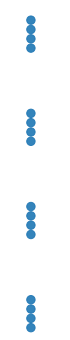

In [11]:
fh = plt.figure(figsize=(1,6))
w_elec = sw.plot_electrode_geometry(recording, figure=fh)

### Properties (and features)

For now we have seen that the `RecordingEctractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. Anything related to a channel can be saved as a property.

Similarly, for `SortingExtractor` objects, anything related to a unit can be stored as a property. In addition, for `SortingExtractor` objects we can also store anything related to spikes as *features* (e.g. waveforms, as we'll see later).

We can check which properties are in the extractor as follows:

In [12]:
print('Shared channel property names')
print(recording.get_shared_channel_property_names())

Shared channel property names
['gain', 'group', 'location', 'name', 'offset']


<a id='preprocess'></a>
# 3. Preprocessing
[back to index](#index)

Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, we will filter the recordings, apply common median reference (CMR) and remove noisy channels. All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

### Bandpass filter

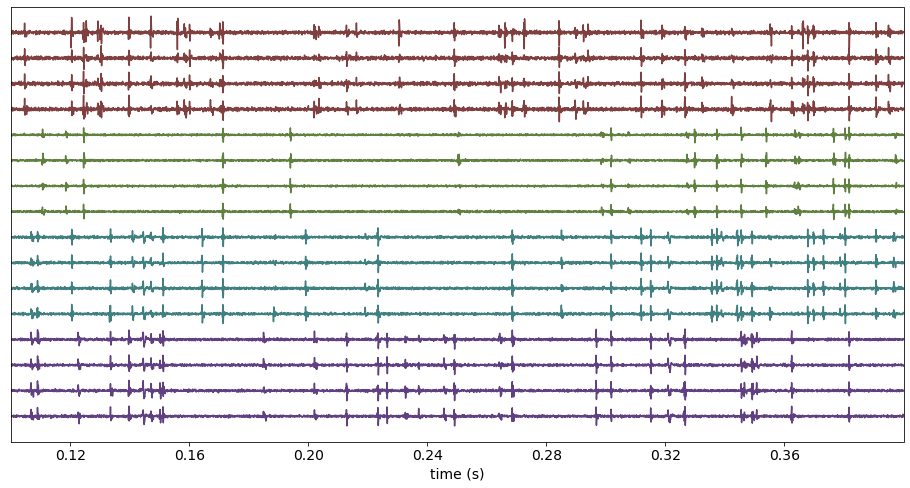

In [13]:
r_filt = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(r_filt, trange=[0.1, 0.4], color_groups=True)

### Common median reference (CMR)

It is often desirable to use a common median reference to remove noise common to all channels.

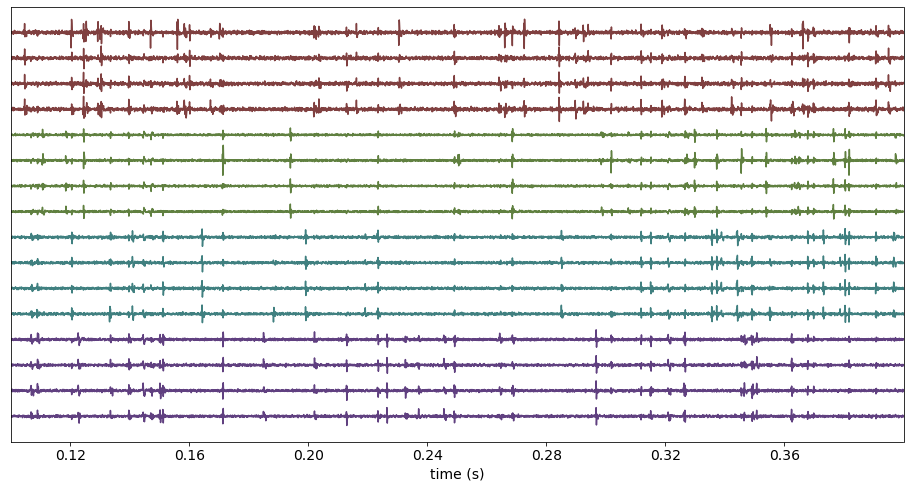

In [14]:
r_cmr = st.preprocessing.common_reference(r_filt, reference='median')
w = sw.plot_timeseries(r_cmr, trange=[0.1, 0.4], color_groups=True)

### Remove bad channels

Some channels look more noisy than others. This could negatively influence the spike sorters, so let's remove some of the noisier channels. Of course for actual analyses it might be better to use a more objective approach. We can do so as follows (alternatively we could create a `SubRecordingExtractor` and specify the channel IDs to keep):

In [15]:
channel_ids = np.array(r_cmr.get_channel_ids())
r_good_channels = st.preprocessing.remove_bad_channels(r_cmr, bad_channel_ids=channel_ids[[0, 3, 5]])
print(f'Channel ids after removing bad channel: {r_good_channels.get_channel_ids()}')
print(f'Channel groups after removing bad channel: {r_good_channels.get_channel_groups()}')

Channel ids after removing bad channel: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after removing bad channel: [0 0 1 1 1 2 2 2 2 3 3 3 3]


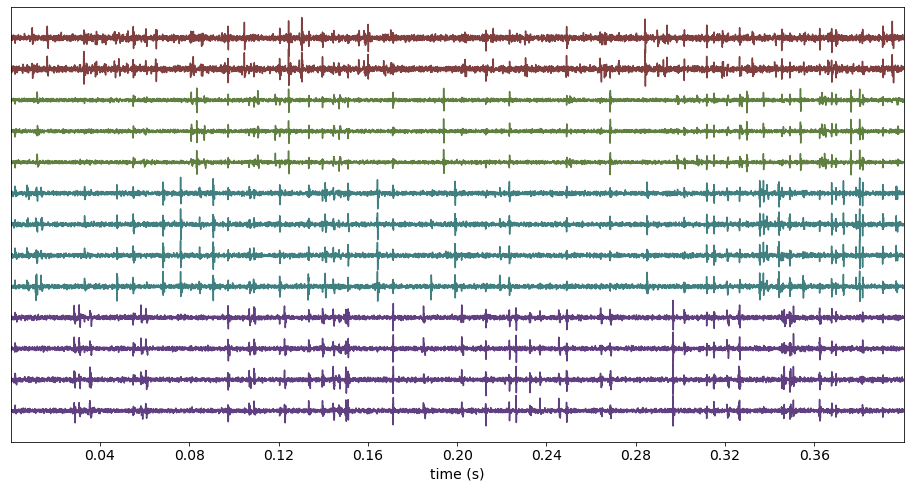

In [20]:
w = sw.plot_timeseries(r_good_channels, trange=[0, 0.4], color_groups=True)

We can also select subsets of data in the time domain with `SubRecordingExtractor`. For illustrative purposes and to speed up computation time of the spike sorters, we will select a 2 min sub-window. 


In [21]:
fs = r_cmr.get_sampling_frequency()
r_sub = se.SubRecordingExtractor(r_good_channels, start_frame=0*fs, end_frame=120*fs)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

<a id='cache'></a>
# 4. Cache data
[back to index](#index)

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to perform those operations (eg. filters, CMR, etc.) at once and **cache** the processed data to a file. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

Note that if the parameter `save_path` is not specified, the cache file will be saved in a temporary folder that will be deleted when the Python session is closed (or the object destroyed). One can get around this by moving the temporary file with `recording_cache.move_to()`, or simply specifying the `save_path` paramter when creating the cache. You can view the directory of the temporary folder with `recording_cache.get_tmp_folder()`.

In [22]:
perma_cache_filename = os.path.join(dir_name, 'cached_unit_data_no_bin_preproc.dat') 
r_cache = se.CacheRecordingExtractor(r_sub, save_path = perma_cache_filename)
print('Temporary folder:\n{}'.format(r_cache.get_tmp_folder()))

Temporary folder:
/tmp/tmpeh2083cx


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [23]:
print(f'Filename: {r_cache.filename}')

Filename: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/cached_unit_data_no_bin_preproc.dat


The cached recording has all the previously loaded information:

In [24]:
print(f'Cached channels: {r_cache.get_channel_ids()}')
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cached channels ids: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after caching: [0 0 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 1.2


If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [25]:
r_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/cached_unit_data_no_bin_preproc.dat',
  'sampling_frequency': 48000,
  'numchan': 13,
  'dtype': 'float32',
  'recording_channels': [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'time_axis': 0,
  'geom': None,
  'file_offset': 0,
  'gain': None,
  'is_filtered': True},
 'key_properties': {'group': array([0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'location': array([[ 0.,  1., nan],
         [ 0.,  2., nan],
         [ 0., 10., nan],
         [ 0., 12., nan],
         [ 0., 13., nan],
         [ 0., 20., nan],
         [ 0., 21., nan],
         [ 0., 22., nan],
         [ 0., 23., nan],
         [ 0., 30., nan],
         [ 0., 31., nan],
         [ 0., 32., nan],
         [ 0., 33., nan]]),
  'gain': array([1., 1., 1., 1., 1., 1., 1.,

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allows us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [26]:
r_cache.dump_to_pickle(os.path.join(dir_name, 'cached_unit_data_no_bin_preproc.pkl'))

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [7]:
r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_unit_data_no_bin_preproc.pkl'))

In [8]:
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels ids: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after caching: [0 0 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 1.2


__Note__: the same caching/dumping mechanisms are available also for all `SortingExtractor` objects.

<a id='spike_sorting'></a>
# 5. Spike sorting
[back to index](#index)

In [ ]:
#TODO are the spikesorters mentioned here indeed used in the end?

We will now run spike sorting on the above recording (`r_cache`). We will use `klusta`, `ironclust`, `mountainsort4`, `spykingcircus` and `trideclous` for this demonstration, to show how easy SpikeInterface makes it to interchengably run different sorters.

First, we need to install the spike sorters we want. There is a complete overview of spike sorters supported by spikeinterface [here](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html), including installation instructions. Note that not all spikesorters work on every setup. Some require Matlab. Some require CUDA. 

We can list all installed spike sorting algorithms with the following convenience function.

In [83]:
ss.installed_sorters()

['herdingspikes', 'klusta', 'mountainsort4', 'spykingcircus']

<a id='klusta'></a>
### Klusta
[back to index](#index)

Install `Klusta` with pip.

In [52]:
!pip install Cython h5py tqdm
!pip install click klusta klustakwik2

  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached klusta-3.0.16-py2.py3-none-any.whl (87 kB)
  Using cached klustakwik2-0.2.6.zip (712 kB)
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-1alxlhvm/klustakwik2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-1alxlhvm/klustakwik2/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-hlwig7as
       cwd: /tmp/pip-install-1alxlhvm/klustakwik2/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  -----------------------------------

We can retrieve the parameters associated with any sorter with the `get_default_params()` function from the `spikesorters` module, as well as corresponding parameter descriptions using `get_params_description()`.

In [48]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [49]:
ss.get_params_description('klusta')

{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'num_starting_clusters': 'Number of initial clusters',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [50]:
ss.run_sorter?

In [51]:
ss.run_klusta?

Since we have tetrodes and we know that they are physically apart, we would like to sort them separately as follows, assigning the `group` property to the `grouping_property` parameter:

In [29]:
sorting_KL = ss.run_klusta(
    r_cache,
    adjacency_radius=5,
    output_folder=os.path.join(dir_name, 'klusta_by_group'),
    grouping_property='group',
    parallel=True
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

SpikeSortingError: Spike sorting failed: klusta returned a non-zero exit code. You can inspect the runtime trace in the klusta.log of the output folder.'

Below you can see that when the `grouping_property` is used a `MultiSortingExtractor` object is returned, containing several `SortingExtractor` objects, which were created separately for each group. 

In [28]:
print(type(sorting_KL))
print(type(sorting_KL.sortings[0]))

<class 'spikeextractors.multisortingextractor.MultiSortingExtractor'>
<class 'spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor'>


In [29]:
print(f'Klusta unit ids (with groups): {sorting_KL.get_unit_ids()}')

Klusta unit ids (with groups): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [30]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

Spike train of a unit: [  41045   41055   41065   55619   55630   55636   55639   55660   70549
   70557   70706   70854   70858   71001   71104   71108   71114   71128
   71140   71145   71151   71177   71182   71186   71191   71207   71251
   71270   71287   71304   71344   71355   71381   71395   71473   71483
   71487   71503   71506   71511   71518   71532   71536   71570   71575
   71594   71598   71605   71622   71627   71631   71658   71665   71671
   71693   71696   71701   71706   71711   71733   71738   71744   71752
   71764   71775   71783   71798   71807   71817   71825   71832   71837
   71841   71849   71860   71866   71876   71881   71888   71908   71913
   71917   71922   71940   71946   71949   71955   71970   71981   71985
   71991   71996   72000   72033   72076   72146   73782   73803   73808
   73821   73826   73830   73841   73846   73859   73865   73876   73893
   73897   73903   73955   73958   73962   74072   74076   74080   74100
   74108   74115   74119   7

We can also visually inspect the data using raster plots.

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

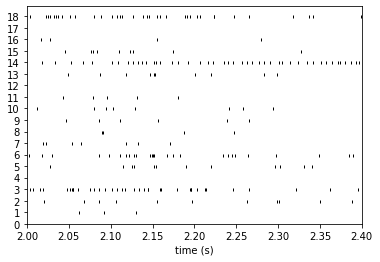

In [51]:
w_rs = sw.plot_rasters(sorting_KL, trange=[2, 2.4])

We can plot the temporal data for comparison, though it can be quite difficult to visually make out spiking events in noisy data. We will see more rigorous ways for assessing spike sorting outputs later on.

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

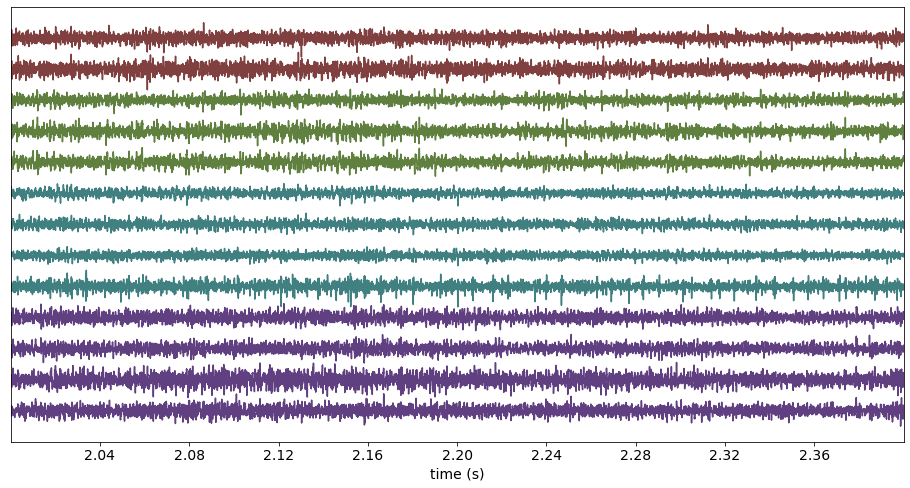

In [36]:
w = sw.plot_timeseries(r_cache, trange=[2, 2.4], color_groups=True)

### Loading spike sorting output from a spike sorting folder

If a spike sorter has been run, you can reload the output as a `SortingExtractor` using the corresponding `spikeextractors` class. Note that if sorting by group/property, single groups must be loaded separately:

In [37]:
sorting_KL_grp = []
for i in range(0, 3):
    sorting_KL_grp.append(se.KlustaSortingExtractor(os.path.join(dir_name, 'klusta_by_group', str(i))))

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
sorting_KL_grp
sorting_KL = se.MultiSortingExtractor(sorting_KL_grp)

In [39]:
sorting_KL

In [40]:
print(f'Klusta unit ids group 0: {sorting_KL_grp[0].get_unit_ids()}')

Klusta unit ids group 0: [0, 2, 3, 4]


### Saving and loading spike sorting output

It is also possible to save spike sorting output in a format of a different spike sorter using the `write_sorting()` method of the sorting extractor of interest. For instance, below we are saving the output from `klusta` in `mountainsort` format. 

In [41]:
se.MdaSortingExtractor.write_sorting(sorting=sorting_KL, save_path=os.path.join(dir_name, 'klusta.mda'))

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

Re-read data from file.

In [7]:
sorting_KL = se.MdaSortingExtractor(
    file_path=os.path.join(dir_name, 'klusta.mda'),
    sampling_frequency=48000
)
print('Unit ids = {}'.format(sorting_KL.get_unit_ids()))
spike_train = sorting_KL.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_KL.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Num. events for unit 1 = 385
Num. events for first second of unit 1 = 0


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

<a id='mountainsort4'></a>
### Mountainsort4
[back to index](#index)

To install Mountainsort4 we simply use pip. It installs quite a large number of packages, so this might take a few minutes. 

In [33]:
!pip install ml_ms4alg

  Using cached ml_ms4alg-0.3.6-py3-none-any.whl (16 kB)
  Using cached isosplit5-0.1.3.tar.gz (17 kB)
  Using cached pybind11-2.6.2-py2.py3-none-any.whl (191 kB)
     |████████████████████████████████| 935 kB 3.0 MB/s eta 0:00:01
  Using cached h5py-3.2.1-cp38-cp38-manylinux1_x86_64.whl (4.5 MB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached mountainlab_pytools-0.7.5-py3-none-any.whl (28 kB)
  Using cached fsspec-0.8.7-py3-none-any.whl (103 kB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
  Using cached toolz-0.11.1-py3-none-any.whl (55 kB)
  Using cached partd-1.1.0-py3-none-any.whl (19 kB)
  Using cached jp_proxy_widget-1.0.10-py2.py3-none-any.whl (1.2 MB)
  Using cached vdom-0.6-py3-none-any.whl (13 kB)
  Using cached numpydoc-1.1.0-py3-none-any.whl (47 kB)
  Using cached locket-0.2.1-py2.py3-none-any.whl (4.1 kB)
  Using cached jupyter_ui_poll-0.1.2-py2.py3-none-any.whl (6.6 kB)
  Using cached Sphinx-3.5.3-py3-none-any.whl (2.8 MB)
  Using cached sphinxcontr

  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-3awm75ww/isosplit5/setup.py'"'"'; __file__='"'"'/tmp/pip-install-3awm75ww/isosplit5/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-arz0jqbb
       cwd: /tmp/pip-install-3awm75ww/isosplit5/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for isosplit5
  Running setup.py clean for isosplit5
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeint

In [69]:
ss.installed_sorters()

['herdingspikes', 'ironclust', 'klusta', 'mountainsort4', 'spykingcircus']

In [70]:
ss.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [71]:
ss.get_params_description('mountainsort4')

{'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood (Use -1 to include all channels in every neighborhood)',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'filter': 'Enable or disable filter',
 'whiten': 'Enable or disable whitening',
 'curation': 'Enable or disable curation',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'clip_size': 'Number of samples per waveform',
 'detect_threshold': 'Threshold for spike detection',
 'detect_interval': 'Minimum number of timepoints between events detected on the same channel',
 'noise_overlap_threshold': 'Noise overlap threshold for automatic curation'}

In [30]:
sorting_MS4 = ss.run_mountainsort4(
    r_cache,
    os.path.join(dir_name, 'mountainsort4_group'),
    grouping_property='group',
    adjacency_radius=5,
    parallel=False,  # on my local machine mountainsort fails when parallel=True, that is not generally the case
    verbose=True,
    filter=False
)
print(f'Mountainsort4 found {len(sorting_MS4.get_unit_ids())} units')

Using 4 workers.
Using tmpdir: /tmp/tmpjsr8s_i9
Num. workers = 4
Preparing /tmp/tmpjsr8s_i9/timeseries.hdf5...
'end_frame' set to 57600
Preparing neighborhood sorters (M=2, N=57600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmpjsr8s_i9
Using 4 workers.
Using tmpdir: /tmp/tmpbbzk_mfb
Num. workers = 4
Preparing /tmp/tmpbbzk_mfb/timeseries.hdf5...
'end_frame' set to 57600
Preparing neighborhood sorters (M=3, N=57600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmpbbzk_mfb
Using 4 workers.
Using tmpdir: /tmp/tmp3kww8i69
Num. workers = 4
Preparing /tmp/tmp3kww8i69/timeseries.hdf5...
'end_frame' set to 57600
Preparing neighborhood sorters (M=4, N=57600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp3kww8i69
Using 4 workers.
Using tmpdir: /tmp/tmpd78hr8yz
Num. workers = 4
Preparing /tmp/tmpd78hr8yz/timeseries.hdf5...
'end_frame' set to 57600
Preparing neighborhood sorters (M=4, N=57600)...
Preparing output...
Done with ms

In [31]:
print(f'Spike train of a unit: {sorting_MS4.get_unit_spike_train(1)}')

Spike train of a unit: [  472  1579  1823  2255  2345  3132  3869  3946  4678  5789  5810  6242
  6264  6410  6699  6725  6938  7077  7256  8059  9778  9799 10239 10722
 11103 11946 12703 12769 12893 13086 13648 14073 14483 14972 15007 15302
 15343 15679 15711 15963 16459 16756 17751 18986 19221 19597 19910 20142
 22564 22645 22720 23303 24087 24588 24605 25474 27773 29293 29829 30106
 32983 33725 35033 36411 36663 37146 37164 37675 39052 39910 40287 41469
 42122 42679 43198 43589 43601 44483 44874 44900 45596 46428 47070 47592
 47796 48173 48474 49386 49542 49657 49798 50300 50474 50654 51585 51710
 51911 52247 52524 56216 57252]


Write spike sorting output to memory.

In [32]:
se.MdaSortingExtractor.write_sorting(sorting=sorting_MS4, save_path=os.path.join(dir_name, 'mountainsort4.mda'))

Read spike sorting output from memory.

In [116]:
sorting_MS4 = se.MdaSortingExtractor(
    file_path=os.path.join(dir_name, 'mountainsort4.mda'),
    sampling_frequency=48000
)
print('Unit ids = {}'.format(sorting_MS4.get_unit_ids()))
spike_train = sorting_MS4.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_MS4.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Num. events for unit 1 = 101
Num. events for first second of unit 1 = 59


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

<a id='ironclust'></a>
### Ironclust
[back to index](#index)

If you haven't already, clone Ironclust github repository to a path of your choice. Here we stay in the same directory. 

In [29]:
!git clone https://github.com/jamesjun/ironclust

Cloning into 'ironclust'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 4964 (delta 131), reused 119 (delta 62), pack-reused 4775
Receiving objects: 100% (4964/4964), 83.82 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (3556/3556), done.
Updating files: 100% (846/846), done.


In [20]:
ss.get_default_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [21]:
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

Next, we set the ironclust path.

In [22]:
ss.IronClustSorter.set_ironclust_path('./ironclust')
ss.IronClustSorter.ironclust_path

Setting IRONCLUST_PATH environment variable for subprocess calls to: /home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust


'/home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust'

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [23]:
ss.installed_sorters()

['herdingspikes',
 'ironclust',
 'klusta',
 'mountainsort4',
 'spykingcircus',
 'tridesclous']

In [24]:
sorting_IC = ss.run_ironclust(
    r_cache, 
    os.path.join(dir_name, 'ironclust_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True,
    filter=False,  # we already filtered
    common_ref_type=None  # we already applied median reference
)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

SpikeSortingError: Spike sorting failed: ironclust returned a non-zero exit code. You can inspect the runtime trace in the ironclust.log of the output folder.'

<a id='spykingcircus'></a>
### SpykingCircus
[back to index](#index)

Installing spyking circus

In [73]:
from getpass import getpass

!echo {getpass()} | sudo -S apt install libmpich-dev

········
Reading package lists... Done: 
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gfortran gfortran-9 hwloc-nox libgfortran-9-dev libgfortran5
  libhwloc-plugins libhwloc15 libmpich12 libxnvctrl0 mpich ocl-icd-libopencl1
Suggested packages:
  gfortran-multilib gfortran-doc gfortran-9-multilib gfortran-9-doc
  libcoarrays-dev libhwloc-contrib-plugins mpich-doc opencl-icd
The following NEW packages will be installed:
  gfortran gfortran-9 hwloc-nox libgfortran-9-dev libgfortran5
  libhwloc-plugins libhwloc15 libmpich-dev libmpich12 libxnvctrl0 mpich
  ocl-icd-libopencl1
0 upgraded, 12 newly installed, 0 to remove and 5 not upgraded.
Need to get 13.0 MB of archives.
After this operation, 55.1 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.


In [72]:
!pip install mpi4py
!pip install spyking-circus --no-binary=mpi4py

In [5]:
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [6]:
ss.get_params_description('spykingcircus')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood',
 'detect_threshold': 'Threshold for spike detection',
 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro',
 'filter': 'Enable or disable filter',
 'merge_spikes': 'Enable or disable automatic mergind',
 'auto_merge': 'Automatic merging threshold',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'whitening_max_elts': 'Max number of events per electrode for whitening',
 'clustering_max_elts': 'Max number of events per electrode for clustering'}

In [74]:
!export PATH=$PATH:$HOME/.local/bin

In [75]:
!printf "%s\n" $PATH

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin:/home/sbuergers/.vscode-server/bin/3c4e3df9e89829dce27b7b5c24508306b151f30d/bin:/home/sbuergers/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/mnt/c/Program
Files
(x86)/VMware/VMware
Player/bin/:/mnt/c/WINDOWS/system32:/mnt/c/WINDOWS:/mnt/c/WINDOWS/System32/Wbem:/mnt/c/WINDOWS/System32/WindowsPowerShell/v1.0/:/mnt/c/WINDOWS/System32/OpenSSH/:/mnt/c/Program
Files/MATLAB/R2020b/bin:/mnt/c/Program
Files/MATLAB/R2017a/bin:/mnt/c/ProgramData/chocolatey/bin:/mnt/c/tools/lxrunoffline:/mnt/c/Program
Files/Docker/Docker/resources/bin:/mnt/c/ProgramData/DockerDesktop/version-bin:/mnt/c/Users/sbuer/AppData/Local/Microsoft/WindowsApps:/mnt/c/Users/sbuer/AppData/Local/Programs/Microsoft
VS
Code/bin:/snap/bin


In [76]:
ss.installed_sorters()

['herdingspikes', 'klusta', 'mountainsort4', 'spykingcircus', 'tridesclous']

In [64]:
sorting_SC = ss.run_spykingcircus(
    r_cache,
    os.path.join(dir_name, 'spykingcircus_group'),
    grouping_property='group',
    adjacency_radius=5,
    parallel=True,
    verbose=True,
    filter=False
)
print(f'Spyking Circus found {len(sorting_SC.get_unit_ids())} units')

TypeError: Object of type int64 is not JSON serializable

Save spike sorting output in mountainsort format.

In [69]:
se.MdaSortingExtractor.write_sorting(sorting=sorting_SC, save_path=os.path.join(dir_name, 'spykingcircus.mda'))

Read spyking circus spike sorting output. 

In [9]:
sorting_SC = se.MdaSortingExtractor( 
    file_path=os.path.join(dir_name, 'spykingcircus.mda'),
    sampling_frequency=48000
)
print('Unit ids = {}'.format(sorting_SC.get_unit_ids()))
spike_train = sorting_SC.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_SC.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Num. events for unit 1 = 1621
Num. events for first second of unit 1 = 9


<a id='tridesclous'></a>
### Tridesclous
[back to index](#index)

In [ ]:
!pip install https://github.com/tridesclous/tridesclous/archive/master.zip

In [5]:
ss.get_default_params('tridesclous')

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'peak_span_ms': 0.7,
 'wf_left_ms': -2.0,
 'wf_right_ms': 3.0,
 'feature_method': 'auto',
 'cluster_method': 'auto',
 'clean_catalogue_gui': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [6]:
ss.get_params_description('tridesclous')

{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'peak_span_ms': 'Span of the peak in ms',
 'wf_left_ms': 'Cut out before peak in ms',
 'wf_right_ms': ' Cut out after peak in ms',
 'feature_method': 'Feature method to use',
 'cluster_method': 'Feature method to use',
 'clean_catalogue_gui': 'Enable or disable interactive GUI for cleaning templates before peeler',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [65]:
# run spike sorting by group
sorting_TRI = ss.run_tridesclous(
    r_cache, 
    os.path.join(dir_name, 'tridescluous_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True
)
print(f'Tridesclous found {len(sorting_TRI.get_unit_ids())} units')

Writing to binary .dat file:   0%|          | 0/1 [00:00<?, ?it/s]

Local copy of recording
DataIO <id: 140340008132768> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/tridescluous_group/0
  sample_rate: 48000.0
  total_channel: 2
  channel_groups: 0 [ch0 ch1]
  nb_segment: 1
  length: 57600
  durations: 1.2 s.
Local copy of recording


Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00, 16.42it/s]

DataIO <id: 140339769012080> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/tridescluous_group/1
  sample_rate: 48000.0
  total_channel: 3
  channel_groups: 0 [ch0 ch1 ch2]
  nb_segment: 1
  length: 57600
  durations: 1.2 s.
Local copy of recording



Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00, 23.61it/s]

DataIO <id: 140340007546448> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/tridescluous_group/2
  sample_rate: 48000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 57600
  durations: 1.2 s.
Local copy of recording


DataIO <id: 140340007546448> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/tridescluous_group/3
  sample_rate: 48000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 57600
  durations: 1.2 s.


SpikeSortingError: Spike sorting failed: Cannot load backend 'Qt5Agg' which requires the 'qt5' interactive framework, as 'headless' is currently running. You can inspect the runtime trace in the tridesclous.log of the output folder.'

Export spike sorting output from tridesclous.

In [46]:
se.MdaSortingExtractor.write_sorting(sorting=sorting_TRI, save_path=os.path.join(dir_name, 'tridesclous.mda'))

Import spike sorting output from tridesclous.

In [10]:
sorting_TRI = se.MdaSortingExtractor( 
    file_path=os.path.join(dir_name, 'tridesclous.mda'),
    sampling_frequency=48000
)
print('Unit ids = {}'.format(sorting_TRI.get_unit_ids()))
spike_train = sorting_TRI.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_TRI.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2]
Num. events for unit 1 = 260
Num. events for first second of unit 1 = 2


<a id='postprocessing'></a>
# 6. Postprocessing
[back to index](#index)

The `postprocessing` submodule of `spiketoolkit` allows us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons. 

Feel free to also browse the [documentation](https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.ht) for postprocessing. 

Let's start by extracting waveforms.

In [9]:
st.postprocessing.get_unit_waveforms?

In [66]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_MS4, ms_before=0.2, ms_after=0.8, verbose=True)

In [67]:
waveforms[1].shape

(101, 13, 288)

In [68]:
avg_waveforms = st.postprocessing.get_unit_templates(r_cache, sorting_MS4, max_spikes_per_unit=200,
                                                     save_as_property=True, verbose=True)

Text(0.5, 1.0, 'Average waveforms for three sample units')

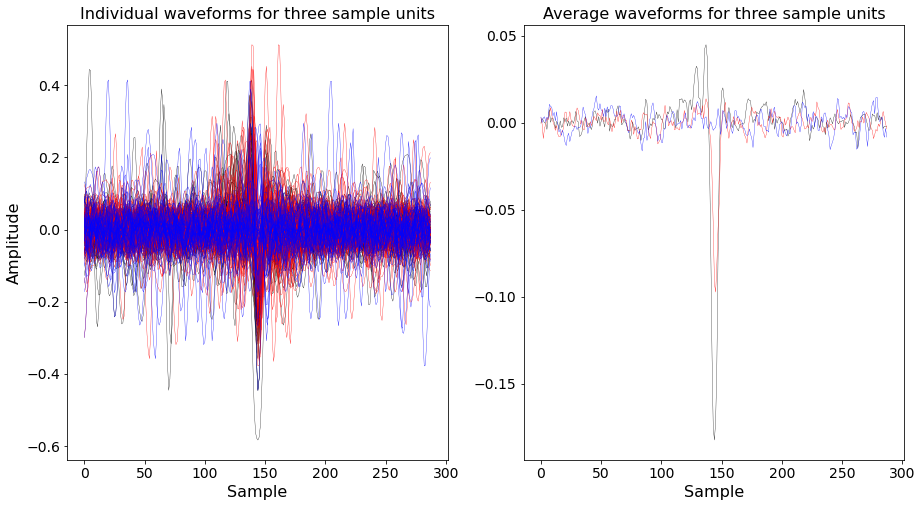

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

ax[0].plot(waveforms[0][:, 0, :].T, color='k', lw=0.3)
ax[0].plot(waveforms[1][:, 0, :].T, color='r', lw=0.3)
ax[0].plot(waveforms[2][:, 0, :].T, color='b', lw=0.3)
ax[0].set_xlabel('Sample', fontsize=16)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_title('Individual waveforms for three sample units', fontsize=16)

ax[1].plot(avg_waveforms[0][0].T, color='k', lw=0.3)
ax[1].plot(avg_waveforms[1][0].T, color='r', lw=0.3)
ax[1].plot(avg_waveforms[2][0].T, color='b', lw=0.3)
ax[1].set_xlabel('Sample', fontsize=16)
ax[1].set_title('Average waveforms for three sample units', fontsize=16)

Similarly, we can get templates, maximum channels, and pca scores. 
When these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [70]:
len(sorting_MS4.get_unit_spike_train(1))

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

101

This is because it can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [71]:
sorting_MS4.get_shared_unit_spike_feature_names()

['amplitudes', 'amplitudes_idxs', 'pca_scores', 'waveforms', 'waveforms_idxs']

In [72]:
print(sorting_MS4.get_unit_spike_features(1, 'waveforms_idxs'))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [73]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_MS4, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions):

Where are waveforms stored? We have seen above that each `Extractor` object has an associated tmp folder. Waveforms (and other features, e.g. pca scores) are stored in this folder as binary files:

In [74]:
tmp_folder = sorting_MS4.get_tmp_folder()
print(tmp_folder)
print([(p.name) for p in tmp_folder.iterdir()])

/tmp/tmp1mfxtipy
['spike_times_amps.raw', 'amplitudes_5.raw', 'pcascores_4.raw', 'waveforms_6.raw', 'waveforms_8.raw', 'spike_clusters_amps.raw', 'spike_times_pca.raw', 'spike_times.raw', 'waveforms_3.raw', 'pcascores_8.raw', 'waveforms_2.raw', 'pcascores_12.raw', 'waveforms_11.raw', 'amplitudes_11.raw', 'waveforms_pca_fit.raw', 'amplitudes_13.raw', 'pcascores_2.raw', 'amplitudes_1.raw', 'waveforms_0.raw', 'spike_clusters.raw', 'pcascores_5.raw', 'pcascores_11.raw', 'waveforms_13.raw', 'pcascores_9.raw', 'amplitudes_0.raw', 'amplitudes_9.raw', 'amplitudes_6.raw', 'pc_features.raw', 'amplitudes_12.raw', 'pcascores_3.raw', 'waveforms_12.raw', 'waveforms_9.raw', 'pcascores_6.raw', 'waveforms_5.raw', 'pcascores_7.raw', 'waveforms_10.raw', 'spike_clusters_pca.raw', 'pcascores_13.raw', 'waveforms_4.raw', 'amplitudes.raw', 'amplitudes_4.raw', 'pcascores_0.raw', 'waveforms_7.raw', 'waveforms_1.raw', 'amplitudes_2.raw', 'pcascores_10.raw', 'amplitudes_3.raw', 'amplitudes_8.raw', 'amplitudes_7.r

In [75]:
waveforms_group = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_MS4,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True
)

Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00, 81.66it/s]

Number of chunks: 1 - Number of jobs: 1


In [117]:
sorting_MS4.get_shared_unit_property_names()

[]

In [77]:
for wf in waveforms_group:
    print(wf.shape)

(72, 2, 288)
(101, 2, 288)
(59, 3, 288)
(15, 3, 288)
(39, 3, 288)
(51, 3, 288)
(38, 4, 288)
(50, 4, 288)
(47, 4, 288)
(73, 4, 288)
(47, 4, 288)
(42, 4, 288)
(67, 4, 288)
(52, 4, 288)


We can use `spikewidgets` to quickly inspect the spike sorting output:

In [78]:
dir_name

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin'

In [79]:
sorting_MS4.get_unit_ids()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

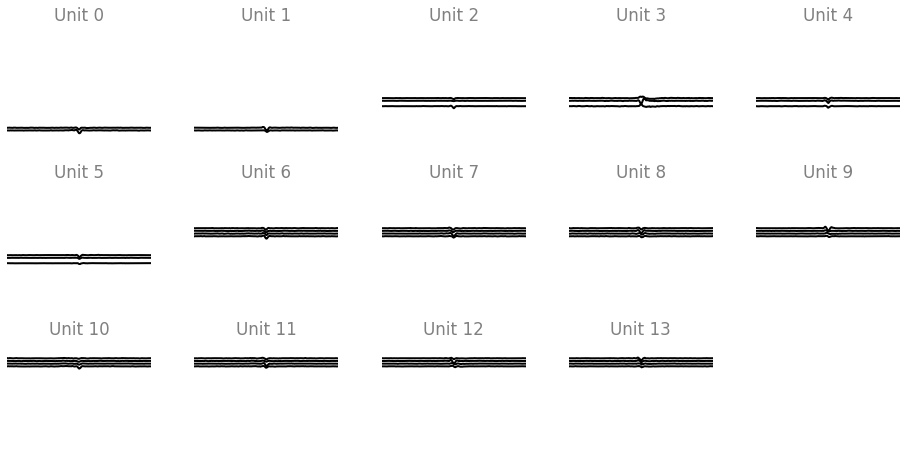

In [80]:
w_wf = sw.plot_unit_templates(sorting=sorting_MS4, recording=r_cache)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

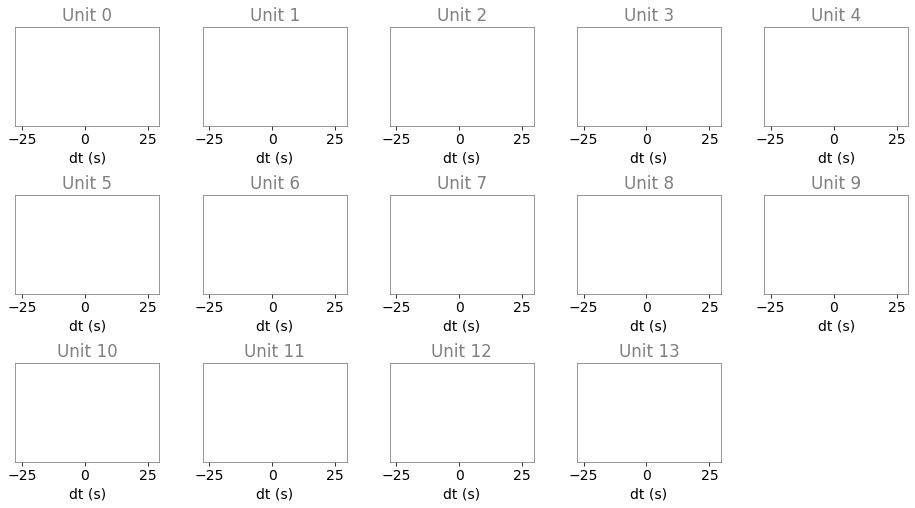

In [81]:
w_acc = sw.plot_autocorrelograms(sorting_MS4)

### Compute extracellular features
[back to index](#index)

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` module of `spiketoolkit` allows one to compute several of these features:

In [82]:
st.postprocessing.get_template_features_list()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [83]:
features = st.postprocessing.compute_unit_template_features(
    r_cache, 
    sorting_MS4, 
    as_dataframe=True, 
    upsampling_factor=10
)
display(features)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikefeatures/features.py:206: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return_to_base_idx = np.empty(waveforms.shape[0], dtype=np.int)


,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.000148,0.000117,-0.109925,2018.716578,4.213246
1,0.000129,0.000106,-0.133798,2350.125208,-8.726942
2,0.000275,0.000087,-0.078052,1639.419662,-2.560658
3,0.000125,0.000090,-0.745280,3377.326343,-160.061807
4,0.000148,0.000092,-0.184420,2042.051059,-8.017446
5,0.000133,0.000098,-0.159771,1415.161824,9.415488
6,0.000125,0.000104,-0.141523,1734.364791,-0.231089
7,0.000135,0.000119,-0.111286,1938.430377,-0.522383
8,0.000127,0.000094,-0.310726,2286.959742,-30.104588
9,0.000133,0.000096,-0.364981,2803.863628,-41.750633


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

### Validation
[back to index](#index)

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:

In [114]:
st.validation.get_quality_metrics_list()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

We can compute a subset of quality metrics using the `compute_quality_metrics` function. 


In [113]:
quality_metrics = st.validation.compute_quality_metrics(
    sorting_MS4, 
    r_cache, 
    metric_names=['firing_rate', 'isi_violation', 'snr'], 
    as_dataframe=True
)
display(quality_metrics)

,firing_rate,isi_violation,snr
0,60.000000,0.233100,4.888308
1,84.166667,0.473833,5.400204
2,49.166667,1.272844,6.885893
3,12.500000,0.000000,10.447522
4,32.500000,0.529648,7.422701
5,42.500000,0.619450,6.519567
6,31.666667,0.278945,5.911790
7,41.666667,1.127832,6.451009
8,39.166667,0.547031,6.242661
9,60.833333,1.133788,7.445354


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

In [36]:
st.postprocessing.get_unit_templates?

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
# Select units with few isi violations.

unit_ids_of_interest = quality_metrics.loc[quality_metrics['isi_violation'] < 10,:].index.values

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


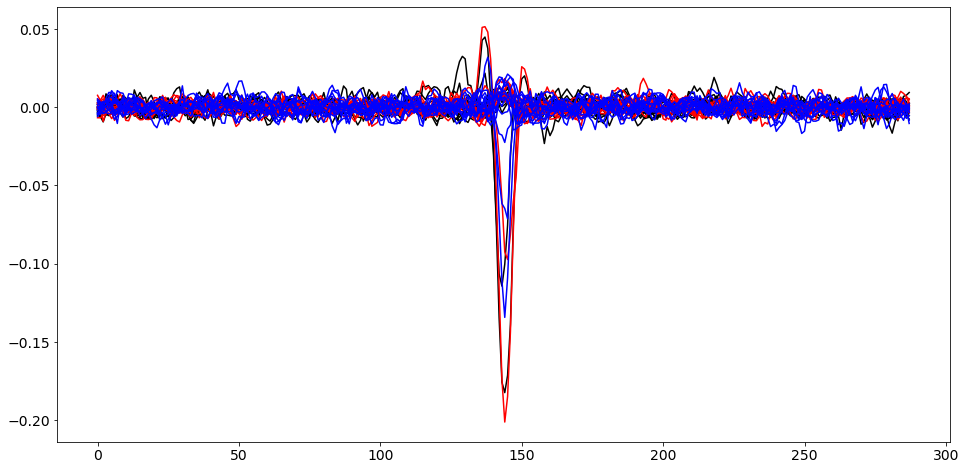

In [86]:
# Get unit templates (average waveforms)

templates = st.postprocessing.get_unit_templates(
    r_cache, sorting_MS4, max_spikes_per_unit=200,
    unit_ids=unit_ids_of_interest,
    save_as_property=True, verbose=True
)

fig, ax = plt.subplots()
ax.plot(templates[0].T, color='k')
ax.plot(templates[1].T, color='r')
ax.plot(templates[2].T, color='b')

<a id="spike_curation"></a>
# 7. Curation
[back to index](#index)

### 1) Manual curation using Phy

To perform manual curation we will export the data to [Phy](https://github.com/cortex-lab/phy). 

In [58]:
st.postprocessing.export_to_phy(
    r_cache, 
    sorting_MS4, 
    output_folder='phy_MS4',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

Converting to Phy format
Number of chunks: 1 - Number of jobs: 1
Fitting PCA of 3 dimensions on 753 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  /home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/phy_MS4
Run:

phy template-gui  /home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/phy_MS4/params.py


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

If you have trouble using the GUI from phy refer to the instructions here: https://github.com/cortex-lab/phy.

In [42]:
!phy template-gui phy_MS4/params.py

13:58:52.593 [W] model:655            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sbuergers'
14:09:23.784 [I] supervisor:711       Change metadata_group for clusters 1 to noise.
14:11:06.826 [I] supervisor:711       Change metadata_group for clusters 0 to noise.
14:11:15.419 [I] supervisor:711       Change metadata_group for clusters 24 to noise.
14:11:23.019 [I] supervisor:711       Change metadata_group for clusters 8 to noise.
14:11:54.570 [I] supervisor:711       Change metadata_group for clusters 20 to good.
14:11:59.993 [I] supervisor:711       Change metadata_group for clusters 22 to noise.
14:12:03.341 [I] supervisor:711       Change metadata_group for clusters 16 to noise.
14:12:05.371 [I] supervisor:711       Change metadata_group for clusters 5 to noise.
14:12:07.768 [I] supervisor:711       Change metadata_group for clusters 2 to noise.
14:12:0

In [37]:
%%capture --no-display
!phy template-gui phy_KL/params.py

After curating the results we can reload it using the PhySortingExtractor:

In [44]:
sorting_MS4_phy_curated = se.PhySortingExtractor('phy_MS4/', exclude_cluster_groups=['noise'])

In [45]:
print(len(sorting_MS4_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_MS4_phy_curated.get_unit_ids()}")

8
Unit ids after manual curation: [3, 6, 9, 12, 18, 20, 25, 26]


In [46]:
[print(sorting_MS4_phy_curated.get_unit_property(i, 'quality')) for i in sorting_MS4_phy_curated.get_unit_ids()]

good
good
good
good
good
good
good
good


[None, None, None, None, None, None, None, None]

### b) Automatic curation based on quality metrics
[back to index](#index)

In [47]:
st.curation.threshold_isi_violations?

In [87]:
snr_thresh = 4
isi_viol_thresh = 0.0015
duration = r_cache.get_num_frames()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
isi_violations = st.validation.compute_isi_violations(
    sorting_MS4, 
    duration_in_frames=r_cache.get_num_frames(), 
    isi_threshold=0.0015
)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

In [89]:
isi_violations

array([0.23310023, 0.47383261, 1.27284379, 0.        , 0.52964787,
       0.61944975, 0.27894543, 1.12783217, 0.54703106, 1.13378834,
       0.72937474, 0.        , 1.43567727, 0.89378078])

In [91]:
sorting_auto_MS4 = st.curation.threshold_isi_violations(sorting_MS4, isi_viol_thresh, 'greater', duration)
#sorting_auto_SC = st.curation.threshold_isi_violations(sorting_SC, isi_viol_thresh, 'greater', duration)

In [92]:
print('Number of units Mountainsort4: {}'.format(len(sorting_auto_MS4.get_unit_ids())))
print('Number of units Spyking Circus: {}'.format(len(sorting_auto_SC.get_unit_ids())))

Number of units Mountainsort4: 2


NameError: name 'sorting_auto_SC' is not defined

In [93]:
sorting_auto_MS4 = st.curation.threshold_snrs(sorting_auto_MS4, r_cache, snr_thresh, 'less')
#sorting_auto_SC = st.curation.threshold_snrs(sorting_auto_SC, r_cache, snr_thresh, 'less')

In [95]:
print('Number of units Mountainsort4: {}'.format(len(sorting_auto_MS4.get_unit_ids())))
#print('Number of units Spyking Circus: {}'.format(len(sorting_auto_SC.get_unit_ids())))

Number of units Mountainsort4: 2


### c) Consensus-based curation
[back to index](#index)

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the comparison module. We first compare and match the output spike trains of the different sorters, and we can then extract a new SortingExtractor with only the units in agreement.

In [87]:
mcmp = sc.compare_multiple_sorters(
    [sorting_auto_SC, sorting_auto_MS4], 
    ['SC', 'MS4'], 
    spiketrain_mode='union',
    verbose=True
)

Multicomaprison step 1: pairwise comparison
  Comparing:  SC  and  MS4
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


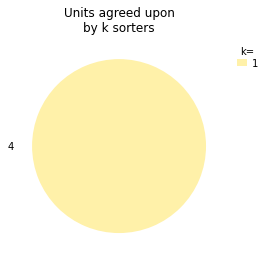

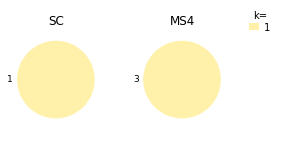

In [88]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [89]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [90]:
agreement_sorting.get_unit_ids()

[]

In [91]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_KL_phy_curated, agreement_sorting)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikewidgets/widgets/agreementmatrixwidget/agreementmatrixwidget.py:72: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  self.ax.matshow(scores.values, cmap='Greens')
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikewidgets/widgets/agreementmatrixwidget/agreementmatrixwidget.py:99: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  self.ax.set_xlim(-0.5, N2-0.5)


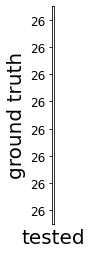

In [92]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr)

Exception: Unit id is invalid

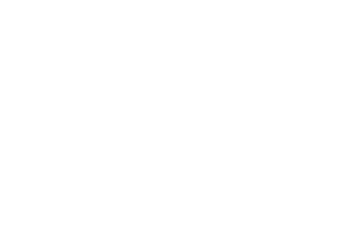

In [93]:
w_wf = sw.plot_unit_templates(sorting=agreement_sorting, recording=r_cache, unit_ids=[1])

In [96]:
st.postprocessing.export_to_phy(
    r_cache, 
    agreement_sorting, 
    output_folder='phy_AGR',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

NameError: name 'agreement_sorting' is not defined

In [69]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id="export_nwb"></a>
# 7. Save to / load from NWB
[back to index](#index)

In this section we briefly go through the process of exporting recording extractor and sorting extractor objects to the `nwb` file format. We will use the `spikeextractors` classes `NwbRecordingExtractor` and `NwbSortingExtractor`. It can be useful to pass metadata to the `nwb` file during export (i.e. data that describes the ecephys data in this case) and we illustrate this here by passing information about the recording device.

In [97]:
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget
from pathlib import Path
import yaml
import pprint

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/spec/namespace.py:206: PendingDeprecationWarning: 
safe_load will be removed, use

  yaml=YAML(typ='safe', pure=True)
  yaml.load(...)

instead
  d = yaml.safe_load(stream)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ruamel/yaml/main.py:1105: PendingDeprecationWarning: 
load will be removed, use

  yaml=YAML(typ='unsafe', pure=True)
  yaml.load(...)

instead
  return load(stream, SafeLoader, version)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/spec/namespace.py:215: PendingDeprecationWarning: 
safe_load will be removed, use

  yaml=YAML(typ='safe', pure=True)
  yaml.load(...)

instead
  specs = yaml.safe_load(stream)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registr

In [98]:
metadata = {'Ecephys': {'Device': [{'name': 'Axona',
                                    'description': 'Axona DacqUSB acquisition system'}]}}

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
type(r_cache)

spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor

In [100]:
metadata

{'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB acquisition system'}]}}

In [6]:
se.NwbRecordingExtractor.write_recording?

In [6]:
dir_name

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin'

In [7]:
from pathlib import Path

In [8]:
nwb_dir = Path(dir_name, 'nwb')

nwb_dir.mkdir(parents=True, exist_ok=True)

In [14]:
se.NwbRecordingExtractor.write_recording(r_cache, nwb_dir / 'axona_tutorial_re3.nwb')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavio

In [108]:
se.NwbSortingExtractor.write_sorting(sorting_MS4, nwb_dir / 'axona_se_MS4.nwb')

Skipping property 'waveforms_channel_idxs' because it has variable size across units.
Skipping feature 'waveforms' because it has variable size across units.


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1309: UserWarning: Description for property repolarization_slope not found in property_descriptions. Setting description to 'no description'
  warnings.warn(
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1309: UserWarning: Description for property recovery_slope not found in property_descriptions. Setting description to 'no description'
  warnings.warn(
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1309: UserWarning: Description for property group not found in property_descriptions. Setting description to 'no description'
  warnings.warn(
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1309: UserWarning: Description for property peak_trough_ratio not found in property_descriptions. Setting description to 'no description'
  warnings.warn(
/mnt/d/s

In [109]:
recording_nwb = se.NwbRecordingExtractor(nwb_dir / 'axona_tutorial_re2.nwb')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [9]:
sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior an

<a id="export_tint"></a>
# 8. Save to / load from TINT
[back to index](#index)

We can export the spike sorted data back to the 'TINT' format in the form of `.X`, `.cut` and `.clu` files. The `.X` files are similar to the tetrode files generated by the Axona acquisition system, except that the spike times are now based on the spike sorting extractor used for the conversion. The `.cut` and `.clu` files contain the unit labels of each spike timestamp.

For the conversion to 'TINT' both a sorting extractor and recording extractor are required. Spike times are read from the sorting extractor and the corresponding waveforms are extracted from the recording extractor. It is always preferable to use a recording extractor based on `.bin` data (i.e. `AxonaRecordingExtractor` instead of `AxonaUnitRecordingExtractor`), because spike times extracted from spike sorters might not exactly correspond to spike times from the thresholding procedure that created the `.X` files from the raw data. When spike times do not correspond exactly, part (or in the worst caes all) of the waveforms will consist of Gaussian noise if based on an `AxonaUnitRecordingExtractor`. 

The `TintConverter` class has the `compare_timestamps_after_conversion()` method to assess the correspondence of timestamps between the `.X` files created from simple thresholding and the `.X` files created using `TintConverter` after spike sorting.

We recommend creating a new folder for the output from `TintConverter` if you do not want to overwrite existing `.X` files. In this case you also need to copy the `.set` file into that new folder. 

In [10]:
from hussaini_lab_to_nwb import TintConverter

We load the recording from `unit` data with no noise to later compare how well the waveforms from the thresholding procedure correspond to the waveforms after spike sorting. To be able to do this comparison we save the `TintConverter` output to a subfolder `tint_conversion`. We also need to copy the set file into this folder to be able to read the data back in afterwards.

In [11]:
recording_unit = se.AxonaUnitRecordingExtractor(filename=filename, noise_std=0)
recording = se.AxonaRecordingExtractor(filename=filename)

sorting = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

In [ ]:
import shutil

output_dir = Path(dir_name, 'tint_conversion')
os.mkdir(output_dir)

shutil.copyfile(filename, output_dir / Path(filename).name)

Convert spike sorted data to TINT format (`.X`, `.cut`, `.clu`)

In [19]:
tc = TintConverter()
tc.write_to_tint(recording=recording_unit,
                 sorting=sorting,
                 set_file=output_dir / Path(filename).name)

df = tc.compare_timestamps_after_conversion(
    filename_old=filename,
    filename_new=output_dir / Path(filename).name
)

display(df.T)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.

Writing axona_sample.1
Writing axona_sample.2
Writing axona_sample.3
Writing axona_sample.4
Write unit labels for tetrode 0 to .cut and .clu
Write unit labels for tetrode 1 to .cut and .clu
Write unit labels for tetrode 2 to .cut and .clu
Write unit labels for tetrode 3 to .cut and .clu


,0,1,2,3
num_signal_snippets_found_by_sorter,129.000000,58.000000,120.000000,96.000000
num_signal_snippets_with_multiple_spikes,27.000000,38.000000,64.000000,70.000000
mean_non_overlapping_samples,18.604651,28.155172,23.941667,34.020833
stderr_non_overlapping_samples,1.360890,2.366776,1.782905,1.774195
group_id,0.000000,1.000000,2.000000,3.000000
num_units,2.000000,4.000000,4.000000,4.000000
num_spikes_thresh,159.000000,59.000000,126.000000,96.000000
num_spikes_sort,173.000000,164.000000,208.000000,208.000000
num_spikes_in_noise,15.000000,55.000000,12.000000,20.000000


In [ ]:
# finally, read with gebaspike